In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Load data
df=pd.read_csv("C:/Cardiofocus_revenue.csv")

In [3]:
df

,Date,Revenue
0,2018-07-31,7.64
1,2018-10-31,7.45
2,2019-01-31,7.52
3,2019-04-30,7.95
4,2019-07-31,7.71
5,2019-10-31,7.63
6,2020-01-31,7.71
7,2020-04-30,6.57
8,2020-07-31,6.34
9,2020-10-31,7.27


In [4]:
# - Parse the date column (expected format like '31-07-18')
# Inspect and prepare
# Standardize column names in case they are slightly different
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Parse date - assume format like '31-07-18' (day-month-two-digit-year)
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')


C:\Users\Dell\AppData\Local\Temp\ipykernel_13088\2389990714.py:7: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')


In [5]:
# Sort by date and set index
df = df.sort_values('date').reset_index(drop=True)
df = df.set_index('date')

In [6]:
# Convert revenue to numeric (coerce errors)
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')


In [7]:
# Fill any remaining missing numeric values by interpolation (only if needed)
df['revenue'] = df['revenue'].interpolate(method='linear')


In [8]:
# Show basic info
summary = df.describe().T


In [9]:
# Determine frequency: check median difference in days
median_diff_days = int(df.index.to_series().diff().median().days)


In [10]:
# Choose seasonal period: if quarterly (approx 90 days) set period=4, if monthly set 12, else infer
# We'll infer: if median_diff_days between 25 and 40 -> monthly (period=12);
# between 80 and 100 -> quarterly (period=4); otherwise we'll attempt to infer period=1
if 25 <= median_diff_days <= 40:
    freq = 'M'
    period = 12
elif 80 <= median_diff_days <= 100:
    freq = 'Q'
    period = 4
else:
    # default to quarterly period=4 if dataset small and looks quarterly
    freq = None
    period = 4

# If freq is set, convert index to PeriodIndex for clearer plotting/treatment, else keep DatetimeIndex
if freq is not None:
    try:
        df = df.asfreq(freq)  # may introduce NaNs if missing periods
    except Exception:
        pass


C:\Users\Dell\AppData\Local\Temp\ipykernel_13088\472135941.py:18: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df = df.asfreq(freq)  # may introduce NaNs if missing periods


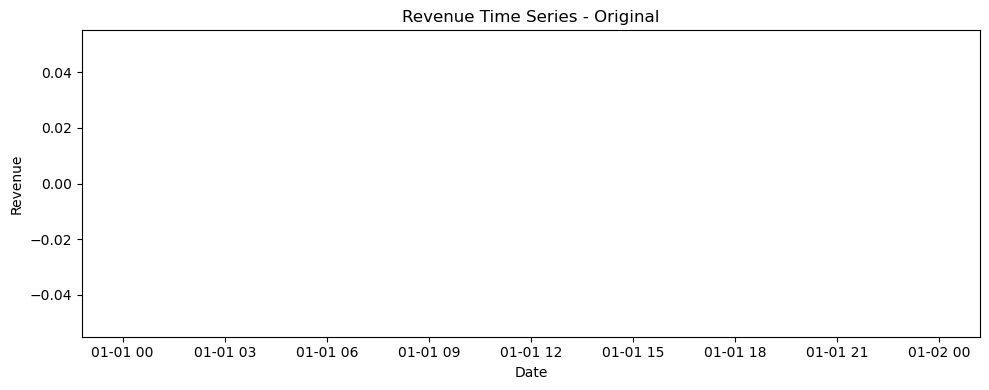

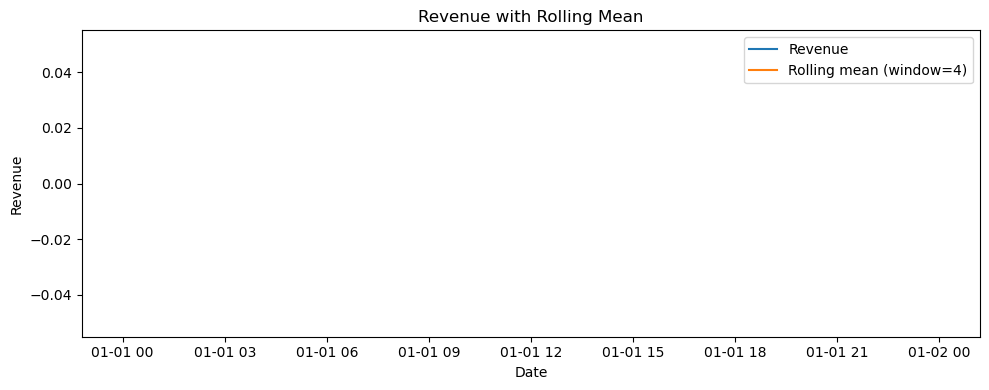

In [14]:
# --- PLOT 1: Original series and rolling mean ---
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['revenue'])
plt.title("Revenue Time Series - Original")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

# Rolling mean (window 4 if quarterly else window 12)
rolling_window = 4 if period == 4 else 12
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['revenue'], label='Revenue')
plt.plot(df['revenue'].rolling(window=rolling_window).mean(), label=f'Rolling mean (window={rolling_window})')
plt.title("Revenue with Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()


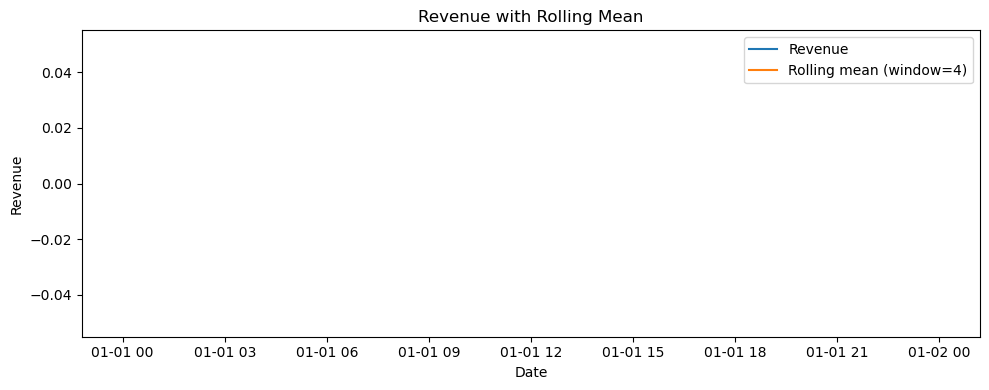

In [15]:
# Rolling mean (window 4 if quarterly else window 12)
rolling_window = 4 if period == 4 else 12
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['revenue'], label='Revenue')
plt.plot(df['revenue'].rolling(window=rolling_window).mean(), label=f'Rolling mean (window={rolling_window})')
plt.title("Revenue with Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Convert to numeric
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# Interpolate missing values
df['revenue'] = df['revenue'].interpolate(method='linear')

# Drop remaining NaN
series = df['revenue'].dropna()

# ADF safe check
if len(series) < 10:
    print("Not enough data for ADF test — need more values.")
elif series.nunique() <= 1:
    print("ADF test cannot run — revenue series is constant.")
else:
    adf_res = adfuller(series, autolag='AIC')
    print("ADF Statistic:", adf_res[0])
    print("p-value:", adf_res[1])


In [16]:
# --- Decomposition ---
# seasonal_decompose needs a complete series with period specified
try:
    decomposition = seasonal_decompose(df['revenue'], period=period, model='additive', extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Decomposition error:", e)


Decomposition error: This function does not handle missing values


In [19]:
# Convert to numeric
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# Interpolate missing values
df['revenue'] = df['revenue'].interpolate(method='linear')

# Drop remaining NaN
series = df['revenue'].dropna()

# ADF safe check
if len(series) < 10:
    print("Not enough data for ADF test — need more values.")
elif series.nunique() <= 1:
    print("ADF test cannot run — revenue series is constant.")
else:
    adf_res = adfuller(series, autolag='AIC')
    print("ADF Statistic:", adf_res[0])
    print("p-value:", adf_res[1])


Not enough data for ADF test — need more values.


In [23]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ensure revenue is numeric
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')

# Interpolate missing values
df['revenue'] = df['revenue'].interpolate(method='linear')
series = df['revenue'].dropna()

# Check before plotting
if len(series) < 10:
    print("Not enough data to plot ACF/PACF (need at least 10 values).")
elif series.nunique() <= 1:
    print("ACF/PACF cannot be plotted because revenue has constant values.")
else:
    plt.figure(figsize=(10, 4))
    plot_acf(series, lags=20, ax=plt.gca())
    plt.title("Autocorrelation (ACF) - Revenue")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plot_pacf(series, lags=20, ax=plt.gca(), method='ywm')
    plt.title("Partial Autocorrelation (PACF) - Revenue")
    plt.tight_layout()
    plt.show()


Not enough data to plot ACF/PACF (need at least 10 values).


In [26]:
# Ensure 'revenue' is numeric
df['revenue'] = pd.to_numeric(df['revenue'], errors='coerce')
df['revenue'] = df['revenue'].interpolate(method='linear')
series = df['revenue'].dropna()

# Summary
summary = series.describe()

# Display sample
sample = df.head(10).reset_index()
print("\nSample data:\n", sample)

print("\nSummary statistics:\n", summary)

# Check if ADF can run
if len(series) < 10:
    print("\n❌ Not enough data for ADF test (need at least 10 values).")
    adf_output = None
elif series.nunique() <= 1:
    print("\n❌ ADF cannot run — 'revenue' contains constant values.")
    adf_output = None
else:
    from statsmodels.tsa.stattools import adfuller
    adf_res = adfuller(series, autolag='AIC')
    adf_output = {
        'ADF Statistic': adf_res[0],
        'p-value': adf_res[1],
        'Used Lag': adf_res[2],
        'Number of Observations': adf_res[3]
    }
    adf_crit = adf_res[4]

# Print ADF results if available
if adf_output:
    print("\nADF test results:")
    for k, v in adf_output.items():
        print(f"  {k}: {v}")

    print("\nADF Critical Values:")
    for level, val in adf_crit.items():
        print(f"  {level}: {val}")
else:
    print("\n⚠️ ADF test was skipped due to data constraints.")



Sample data:
         date  revenue
0 2018-09-30      NaN
1 2018-12-31      NaN
2 2019-03-31      NaN
3 2019-06-30      NaN
4 2019-09-30      NaN
5 2019-12-31      NaN
6 2020-03-31      NaN
7 2020-06-30      NaN
8 2020-09-30      NaN
9 2020-12-31      NaN

Summary statistics:
 count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: revenue, dtype: float64

❌ Not enough data for ADF test (need at least 10 values).

⚠️ ADF test was skipped due to data constraints.
